<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/age1SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=fbe1573aa16347471d26b35cd4f2654875ffc50b9e39da7208bf064a1cecf7c9
  Stored in directory: /root/.cache/pip/wheels/c8/29/ba/ee521d9a6af783a1e1efb1831fe4afdf526613849b3f58175b
Successfully built minisom


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("Agenormalized_with_winners_cleaned.csv")


party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    'Liberal Democrat': (0.98, 0.6, 0.1),  # Orange
    'Green': (0, 0.6, 0.3),         # Dark Green
    'The Brexit Party': (0.6, 0.2, 0.8) #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = data.drop(columns=labeling_columns)

#Feature Scaling
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(data[features])

robust_scaler = RobustScaler()
normalized_features = robust_scaler.fit_transform(features)



normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = data[labeling_columns]

print(normalized_df.head())
print(normalized_df.shape[0])


   Aged 15 years and under  Aged 16 to 24 years  Aged 25 to 34 years  \
0                 0.179178             0.057669             0.912297   
1                -0.216812            -0.120101            -0.484629   
2                 0.967847            -0.444699            -0.889161   
3                -0.477082            -0.208513            -0.131283   
4                -0.703953            -0.744648            -1.418097   

   Aged 35 to 49 years  Aged 50 to 64 years  Aged 65 years and over  \
0             0.668425            -0.432198               -0.452588   
1            -0.530897             0.375240                0.547315   
2             0.960576            -0.242508               -0.015246   
3            -0.429599             0.528633                0.407457   
4            -0.785829             0.857573                1.255151   

  Westminster Parliamentary constituencies     Winning Party  \
0                                aldershot      Conservative   
1           

In [ ]:
# import math
# Initialize and Train SOM
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))
# n_neurons = int(math.ceil(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)

# Train the SOM
num_iterations = 3000
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 0.4129553270590936


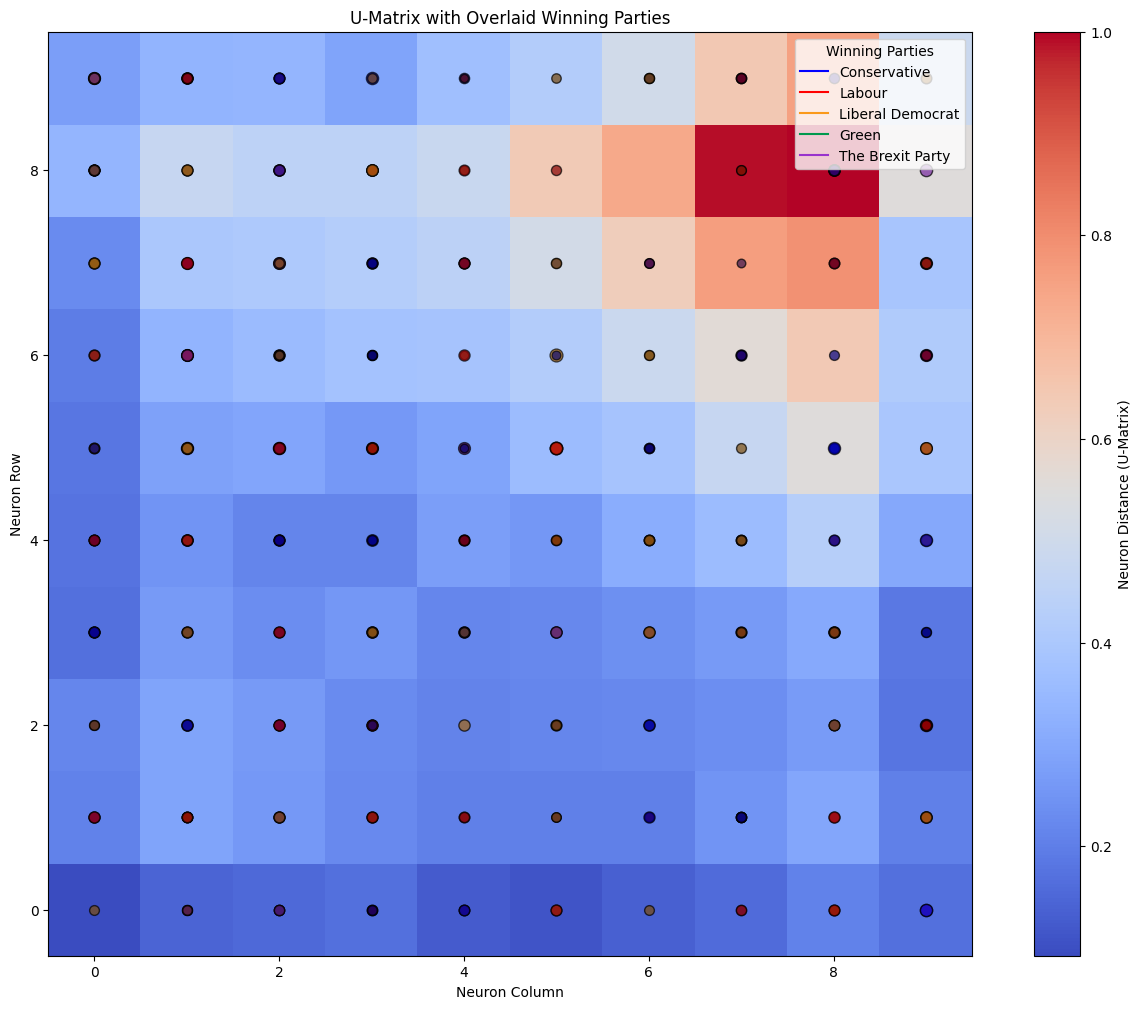

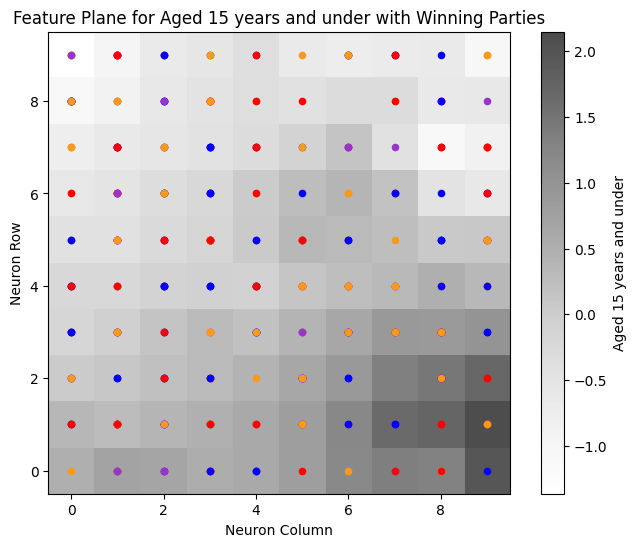

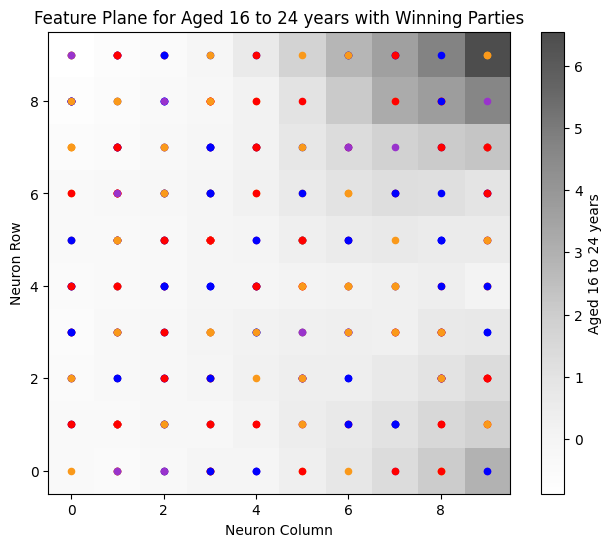

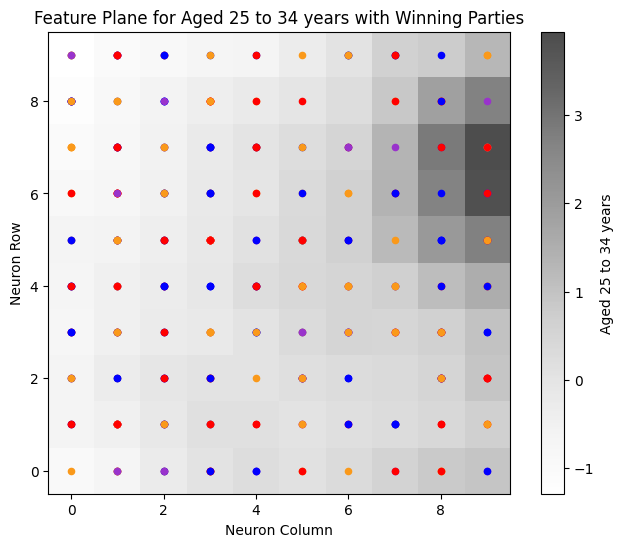

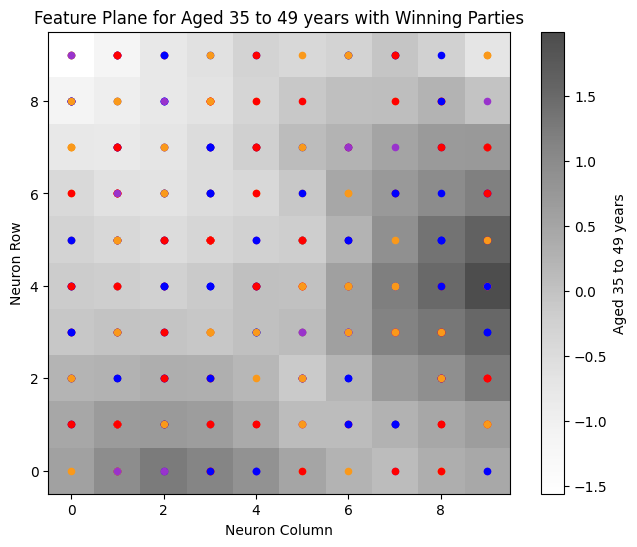

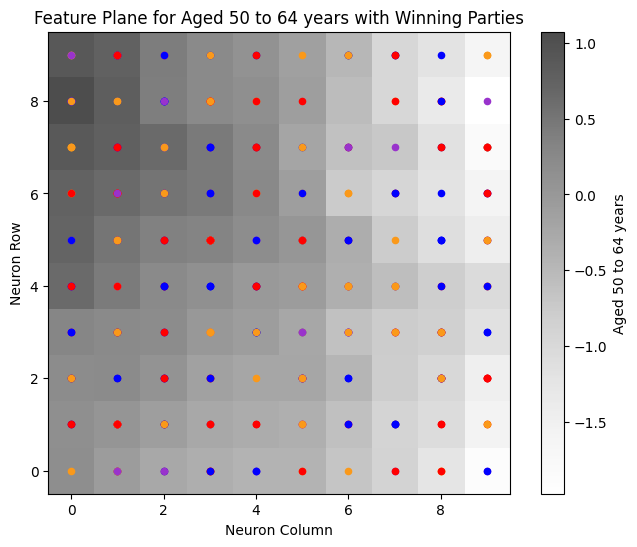

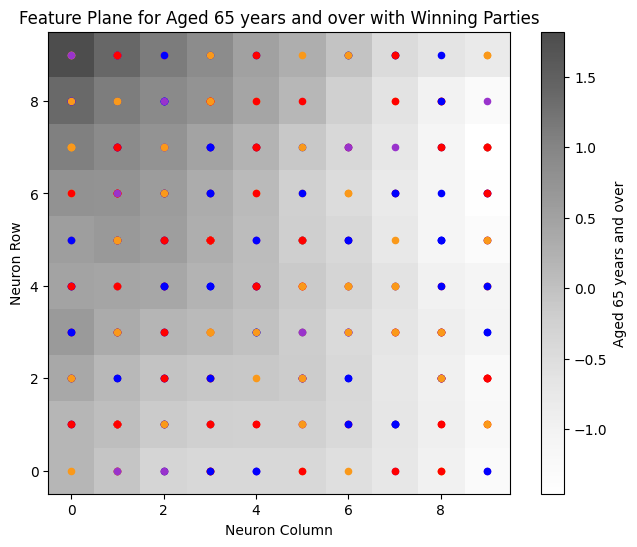

In [ ]:
#U-Matrix implementation


u_matrix = som.distance_map()
#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U-Matrix with Overlaid Winning Parties")
plt.imshow(u_matrix.T, cmap='coolwarm', origin='lower')
plt.colorbar(label="Neuron Distance (U-Matrix)")

# Overlayying the winning parties on the grid
for _, row in normalized_df.iterrows():
    neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
    party = row['Winning Party']
    vote_share = row['Winning Vote Share']

    if party in party_colors:
        base_color = np.array(party_colors[party])
        adjusted_color = np.clip(base_color * vote_share, 0, 1)

        plt.scatter(neuron_col, #+ 0.3 * np.random.rand(),
                    neuron_row, #+ 0.3 * np.random.rand(),
                    s=vote_share * 100,
                    color=adjusted_color,
                    alpha=0.7, edgecolors='k')

# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")
plt.show()

for feature_name in features.columns:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane, cmap='Greys', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {feature_name} with Winning Parties")
    plt.xlabel("Neuron Column")
    plt.ylabel("Neuron Row")

    for index, row in normalized_df.iterrows():
        neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
        winning_party = row['Winning Party']
        if winning_party in party_colors:
          plt.scatter(neuron_col, neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=20)

    plt.show()




